In [1]:
#IMPPORT 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import animation
import warnings
warnings.filterwarnings('ignore')
import math 
import numpy as np
import matplotlib.cm as cm
from collections import deque
%matplotlib inline
from scipy import stats
from decimal import *
import random 
import scipy as sp
import collections
import heapq 
import seaborn as sns
sns.set()
sns.set(style = "ticks",palette = "pastel")
from copy import deepcopy
import matplotlib.patches as mpatches

In [2]:


def rij(i,j):
    r = (i.x[0] -j.x[0])**2 + (i.x[1] - j.x[1])**2
    return r

# veloctiy diff
def vij(i,j):
    v = (i.v[0] -j.v[0])**2 + (i.v[1] - j.v[1])**2
    return v

# inner product of r and v
def rv_ip(i,j):
    ip = np.dot(i.x-j.x, i.v-j.v)
    
    return ip

# expected time of collision of particle i and j 
def collision_particle(i,j):
    rv = rv_ip(i,j)
    r2 = rij(i,j)
    v2 = vij(i,j)
    dt = (r2 - (i.radius + j.radius)**2)/(-rv + np.sqrt(rv**2- v2*(r2 - (i.radius + j.radius)**2)))
    if np.isnan(dt): 
        return 10000
    return dt


# expected time of collision between particle and wall 
def collision_wall(i, R): 
    xv = np.dot(i.x, i.v)
    x2 = i.x[0]**2 + i.x[1]**2
    v2 = i.v[0]**2 + i.v[1]**2
    dt = (-xv + np.sqrt(xv**2 + v2*((R-i.radius)**2 - x2)))/v2
    if np.isnan(dt): 
        return 10000
    return dt

def update_pos(i, dti, index):
    
    global xs
    current_x = i.x
    #storage
    ts = np.arange(0, dti, 0.01)
    for t in ts:
        xs[index].append(current_x + t*i.v)
        
    i.x = i.x + dti*i.v   
    return 

# update position of i and j after collision
def update_velocity(i,j):
    
    if j is None: # collision with wall
        i.v = i.v - (2/(R-i.radius)**2) * np.dot(i.x,i.v)*i.x
        
    else: # collision with each other
        rhat = (i.x - j.x)/(i.radius + j.radius)
        vhat = i.v-j.v
        Mij = 2/(1/i.mass + 1/j.mass)
        Pij = Mij*np.dot(rhat, vhat)*rhat
        i.v= i.v - Pij/i.mass
        j.v = j.v + Pij/j.mass

    return 

In [3]:
# initial setups 

# puts atoms in a circle spaced like a square
def init_disk_square(R,N):
    atoms = []
    per_side = int(np.ceil(np.sqrt(N)))
    len_square = int(np.sqrt(2)*R)
    r = 2
    grid = np.linspace(-len_square/2+r, len_square/2-r, per_side)
    i=0
    j=0
    k =0 
    
    while i < N:
        if k == per_side:
            k =0 
            j = j+ 1
        x = grid[j]
        y = grid[k]
        vx = float(random.randrange(-20,20)) # random initial v
        vy = float(random.randrange(-20,20)) 
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
        k = k+1
        
    return atoms

In [4]:
class Atom:

    def __init__(atom, x, y, vx, vy, radius, mass):
        
        atom.x = np.array((x, y))
        atom.v = np.array((vx, vy))
        atom.radius = radius
        atom.mass = mass

# Event
Looped over collision

In [5]:
def simulate_collision(R,N,C,atoms):
    global xs
    tracking = []
    xs = [[atoms[i].x] for i in range(N)]

    heap_list = []
    L = [-1 for i in range(N)]# storage of collision times per particle
    tau = 0 #time of last collision
    for i in range(N):
        for j in range(i+1, N):
            # estimate collision time 
            t_star = collision_particle(atoms[i], atoms[j]) + tau
            heap_list.append((t_star, tau, i, j))
        # estimate wall collision time 
        t_star = collision_wall(atoms[i],R) + tau
        heap_list.append((t_star, tau, i, -1))
    heapq.heapify(heap_list) 

    for c in range(C):
        invalid = 1
        while invalid:

            col = heapq.heappop(heap_list)

            if col[0] < col[1] or col[1] < (L[col[2]]- 1e-12) or (col[1] < (L[col[3]]- 1e-12) and col[3]!= -1):
                invalid = 1 
            else:
                invalid = 0

        for i in range(N):
            update_pos(atoms[i], col[0] - tau, i)  

        tau = col[0] # update time to current collision time
        tracking.append(col)
        if col[3] == -1: # collision with wall
            i = col[2]
            L[i] = tau
            update_velocity(atoms[i], None)
            for j in range(N):
                if j!= i:
                    t_star = collision_particle(atoms[i], atoms[j]) + tau
                    heapq.heappush(heap_list,(t_star, tau, i, j))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, col[2], -1))

        else: #collision with other particle
            i = col[2]
            j = col[3]
            L[i] = tau
            L[j] = tau
            update_velocity(atoms[i],atoms[j])
            for a in range(N):
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[i], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[2], a))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, i, -1))

            for a in range(N): 
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[j], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[3], a))
            t_star = collision_wall(atoms[j],R) + tau
            heapq.heappush(heap_list, (t_star, tau, j, -1))      
    return tau

 # Energy loss:

In [555]:
R = 100
N= 50
C = 100
atoms = []
atoms = init_disk_square(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]

energy_init = 0
for i in range(N):
    energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
simulate_collision(R,N,C,atoms)

energy_final = 0
for i in range(N):
    energy_final = energy_final + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
print('Energy lost: %.10f' %(energy_init-energy_final))     



Energy lost: 0.0000000001


# Reversibility:

Testing reversibility on one case:

In [596]:
R = 100
N= 100
C = 100
atoms = []
atoms = init_disk_square(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]

tau = simulate_collision(R,N,C,atoms)
dt = 0.0001
# advance forward for a bit more time for reversal test later
for i in range(N):
    update_pos(atoms[i],dt, i)  

end_time = tau  + dt
# get velocities 
vs = [atoms[i].v for i in range(N)]
#reverse velocities
for i in range(N):
    atoms[i].v = -1*vs[i]

tau_r = simulate_collision(R,N,C,atoms)
#update to final position
for i in range(N):
    update_pos(atoms[i], end_time - tau_r, i) 
x_end = [atoms[i].x for i in range(N)]  

err = 0
for i in range(N):
    err = err + np.abs(sum(x_start[i] - x_end[i]))
print('The error after reversing 100 collisions is: %.10f' %err)

The error after reversing 100 collisions is: 0.0000000021


Testing reversibility on different number of collisions (repeated 5 times per number of collisions)

In [566]:
R = 100

Cs = [10,20,50,100,200,300, 400,450, 500]
err_c = []
for C in Cs:
    errors = []
    for k in range(5):
        atoms = init_disk_square(R,N)
        v_init = [atoms[i].v for i in range(N)]
        x_start =  [atoms[i].x for i in range(N)]

        tau = simulate(R,N,C,atoms)
        dt = 0.0001
        # advance forward for a bit more time for reversal test later
        for i in range(N):
            update_pos(atoms[i],dt, i)  

        end_time = tau  + dt
        # get velocities 
        vs = [atoms[i].v for i in range(N)]
        #reverse velocities
        for i in range(N):
            atoms[i].v = -1*vs[i]

        tau_r = simulate(R,N,C,atoms)
        #update to final position
        for i in range(N):
            update_pos(atoms[i], end_time - tau_r, i) 
        x_end = [atoms[i].x for i in range(N)]  

        err = 0
        for i in range(N):
            err = err + np.abs(sum(x_start[i] - x_end[i]))
        errors.append(err)
    err_c.append(np.mean(errors))

[]

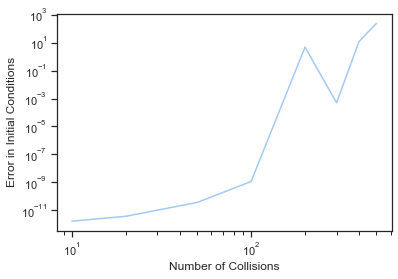

In [567]:
plt.plot(Cs,err_c)
plt.xlabel('Number of Collisions')
plt.ylabel('Error in Initial Conditions')
plt.loglog()
plt.legend()
#plt.savefig('reversibility1.png', bbox_inches='tight', dpi = 800)

Reversibility on Time 

In [6]:
def simulate_time(R,N,T,atoms):
    global xs
    tracking = []
    xs = [[atoms[i].x] for i in range(N)]

    heap_list = []
    L = [-1 for i in range(N)]# storage of collision times per particle
    tau = 0 #time of last collision
    for i in range(N):
        for j in range(i+1, N):
            # estimate collision time 
            t_star = collision_particle(atoms[i], atoms[j]) + tau
            heap_list.append((t_star, tau, i, j))
        # estimate wall collision time 
        t_star = collision_wall(atoms[i],R) + tau
        heap_list.append((t_star, tau, i, -1))
    heapq.heapify(heap_list) 

    while 1:
        invalid = 1
        while invalid:

            col = heapq.heappop(heap_list)

            if col[0] < col[1] or col[1] < (L[col[2]]- 1e-12) or (col[1] < (L[col[3]]- 1e-12) and col[3]!= -1):
                invalid = 1 
            else:
                invalid = 0
        
        if col[0] >=T:
            for i in range(N):
                update_pos(atoms[i],T - tau, i)  
            break
            
        for i in range(N):
            update_pos(atoms[i], col[0] - tau, i)  

        tau = col[0] # update time to current collision time
        tracking.append(col)
        if col[3] == -1: # collision with wall
            i = col[2]
            L[i] = tau
            update_velocity(atoms[i], None)
            for j in range(N):
                if j!= i:
                    t_star = collision_particle(atoms[i], atoms[j]) + tau
                    heapq.heappush(heap_list,(t_star, tau, i, j))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, col[2], -1))

        else: #collision with other particle
            i = col[2]
            j = col[3]
            L[i] = tau
            L[j] = tau
            update_velocity(atoms[i],atoms[j])
            for a in range(N):
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[i], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[2], a))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, i, -1))

            for a in range(N): 
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[j], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[3], a))
            t_star = collision_wall(atoms[j],R) + tau
            heapq.heappush(heap_list, (t_star, tau, j, -1))      
    return

In [571]:
R = 100
N= 100
T= 12
atoms = []
atoms = init_disk_square(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]

simulate_time(R,N,T,atoms)

# get velocities 
vs = [atoms[i].v for i in range(N)]
#reverse velocities
for i in range(N):
    atoms[i].v = -1*vs[i]

simulate_time(R,N,T,atoms)
x_end = [atoms[i].x for i in range(N)]  

err = 0
for i in range(N):
    err = err + np.abs(sum(x_start[i] - x_end[i]))
print('The error after T=5 is: %.10f' %err)



The error after T=5 is: 2.4296633680


In [573]:
R = 100
Ns= [50,100,200]
Ts = [1,2,5,8,10,12,15]
err_c = [[] for i in range(len(Ns))]
count = 0
for N in Ns:
    for T in Ts:
        errors = []
        for k in range(5):
            atoms = init_disk_square(R,N)
            v_init = [atoms[i].v for i in range(N)]
            x_start =  [atoms[i].x for i in range(N)]

            simulate_time(R,N,T,atoms)
            
            # get velocities 
            vs = [atoms[i].v for i in range(N)]
            #reverse velocities
            for i in range(N):
                atoms[i].v = -1*vs[i]

            simulate_time(R,N,T,atoms)
            x_end = [atoms[i].x for i in range(N)]  

            err = 0
            for i in range(N):
                err = err + np.abs(sum(x_start[i] - x_end[i]))
            errors.append(err)
        err_c[count].append(np.mean(errors))
        
    print(count)
    count +=1

0
1
2


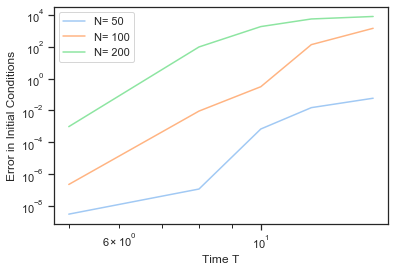

In [581]:
for i in range(len(Ns)):
    plt.plot(Ts[2:],err_c[i][2:], label = 'N= %d'%Ns[i])
    plt.xlabel('Time T')
    plt.ylabel('Error in Initial Conditions')
plt.loglog()
plt.legend()
plt.savefig('reversibility2.png', bbox_inches='tight', dpi = 800)

# Reversibility after Pertubation

In [ ]:
R = 100
N= 100
C = 100
atoms = []
atoms = init_disk_square(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]

tau = simulate_collision(R,N,C,atoms)
dt = 0.0001
# advance forward for a bit more time for reversal test later
for i in range(N):
    update_pos(atoms[i],dt, i)  

end_time = tau  + dt
# get velocities 
vs = [atoms[i].v for i in range(N)]
#reverse velocities
for i in range(N):
    atoms[i].v = -1*vs[i]
    
i = random.randrange(N)
angle = np.tan(atoms[i].v[1]/atoms[i].v[0])
mag = np.sqrt(atoms[i].v[1]**2 + atoms[i].v[0]**2)
new_angle = 1.01*angle 
atoms[i].v[0] = mag*np.cos(new_angle)
atoms[i].v[1] = mag*np.sin(new_angle)

tau_r = simulate_collision(R,N,C,atoms)
#update to final position
for i in range(N):
    update_pos(atoms[i], end_time - tau_r, i) 
x_end = [atoms[i].x for i in range(N)]  

err = 0
for i in range(N):
    err = err + np.abs(sum(x_start[i] - x_end[i]))
print('The error after reversing 100 collisions is: %.10f' %err)

In [80]:
len(x_reversed)

5

In [89]:
R = 100
N= 100
Ts= [4,6, 8, 10,12]
atoms = init_disk_square(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]
x_reversed = [[] for i in range(len(Ts))]
errors =[]
count = 0
r_atom = random.randrange(N)
for T in Ts:
    for i in range(N):
        atoms[i].x = x_start[i]
        atoms[i].v = v_init[i]
    
    simulate_time(R,N,T,atoms)

    # get velocities 
    vs = [atoms[i].v for i in range(N)]
    #reverse velocities
    for i in range(N):
        atoms[i].v = -1*vs[i]
    # perturb
    i = r_atom
    angle = np.arctan(atoms[i].v[1]/atoms[i].v[0])
    mag = np.sqrt(atoms[i].v[1]**2 + atoms[i].v[0]**2)
    new_angle = np.abs(1.01*angle) 
    ix = np.sign(atoms[i].v[0])
    iy = np.sign(atoms[i].v[1])
    atoms[i].v[0] = ix*mag*np.abs(np.cos(new_angle))
    atoms[i].v[1] = iy*mag*np.abs(np.sin(new_angle))

    simulate_time(R,N,T,atoms)
    x_end = [atoms[i].x for i in range(N)]  

    err = 0
    for i in range(N):
        err = err + np.abs(sum(x_start[i] - x_end[i]))
    errors.append(err)
    x_reversed[count]= x_end
    count +=1
    
    #print('The error after T=5 is: %.10f' %err)



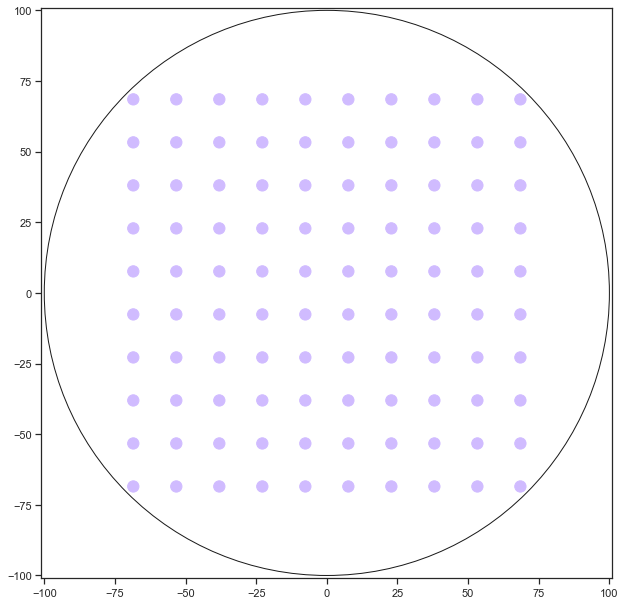

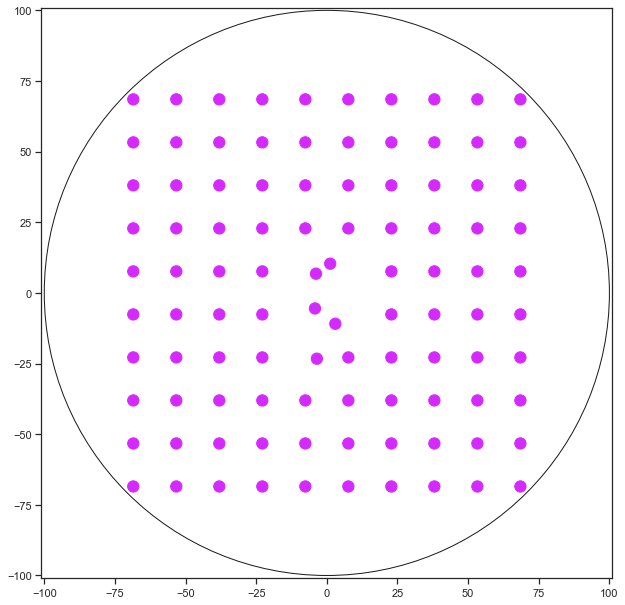

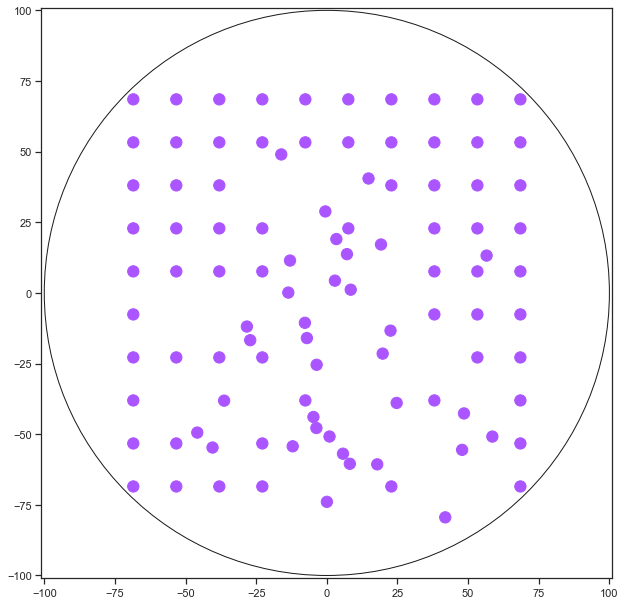

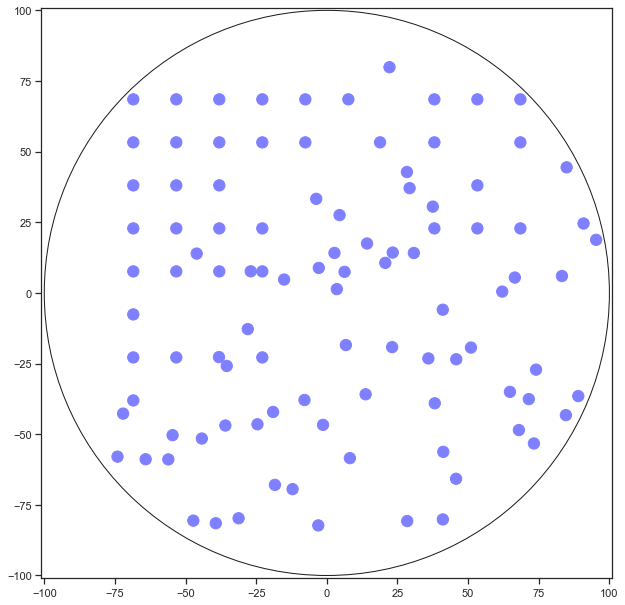

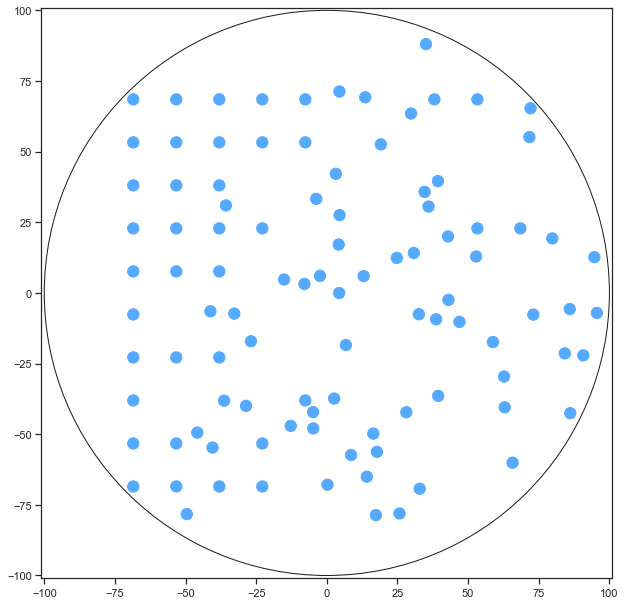

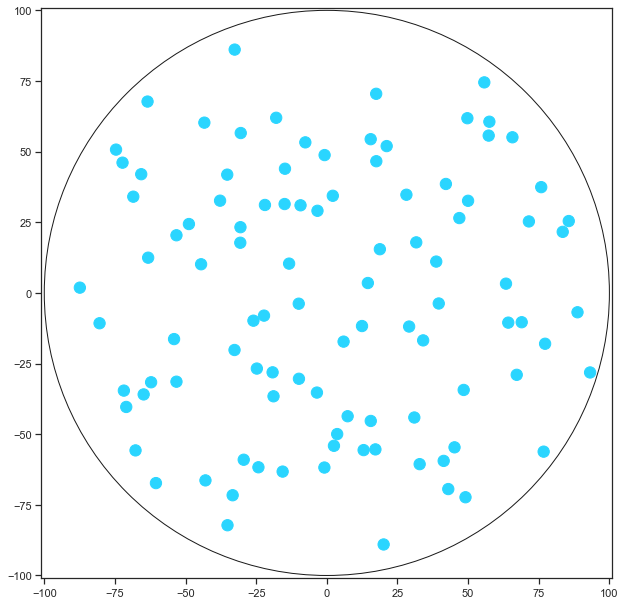

In [91]:
%matplotlib inline
R = 100
N= 100
atoms = init_disk_square(R,N)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_ylim(-(R+1),(R+1))
ax.set_xlim(-(R+1),(R+1))
ax.add_artist(circle1)
#patch = []
for i in range(N):  
    circle2 = plt.Circle((x_start[i][0], x_start[i][1]), 2, color='m', alpha = 1)
    ax.add_artist(circle2)
#patch.append(mpatches.Patch(color='k', label='Original IC'))
colors =  sns.color_palette("cool_r", len(Ts))   
#colors = ['r','b','c']
ax.set_aspect(1)
#plt.savefig('IC_N100R100.png', bbox_inches='tight', dpi = 800)

for t,c in zip(range(len(Ts)), colors):
    circle1 = plt.Circle((0, 0), R, color='k', fill = False)
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.set_ylim(-(R+1),(R+1))
    ax.set_xlim(-(R+1),(R+1))
    ax.add_artist(circle1)
    for i in range(N):
        circle3 = plt.Circle((x_reversed[t][i][0], x_reversed[t][i][1]), 2, color= c, alpha = 1)
        ax.add_artist(circle3)
    ax.set_aspect(1)
    plt.savefig('IC_N100R100_T%d.png'%Ts[t], bbox_inches='tight', dpi = 800)
    #patch.append(mpatches.Patch(color=c, label='T = %d' %Ts[t]))

#plt.legend(handles=patch)
#ax.set_aspect(1)




In [104]:
R = 100
N= 100
Ts= [4,6, 8, 10,12,15]
atoms = init_disk_square(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]
#x_reversed = [[] for i in range(len(Ts))]
p_angle = [1.01,1.02,1.05,1.1]
errors =[[] for i in range(len(p_angle))]
count = 0
r_atom = random.randrange(N)

for p in p_angle:
    for T in Ts:
        for i in range(N):
            atoms[i].x = x_start[i]
            atoms[i].v = v_init[i]

        simulate_time(R,N,T,atoms)

        # get velocities 
        vs = [atoms[i].v for i in range(N)]
        #reverse velocities
        for i in range(N):
            atoms[i].v = -1*vs[i]
        # perturb
        i = r_atom
        angle = np.arctan(atoms[i].v[1]/atoms[i].v[0])
        mag = np.sqrt(atoms[i].v[1]**2 + atoms[i].v[0]**2)
        new_angle = np.abs(p*angle) 
        ix = np.sign(atoms[i].v[0])
        iy = np.sign(atoms[i].v[1])
        atoms[i].v[0] = ix*mag*np.abs(np.cos(new_angle))
        atoms[i].v[1] = iy*mag*np.abs(np.sin(new_angle))

        simulate_time(R,N,T,atoms)
        x_end = [atoms[i].x for i in range(N)]  

        err = 0
        for i in range(N):
            err = err + np.abs(sum(x_start[i] - x_end[i]))
        errors[count].append(err)
        #x_reversed[count]= x_end
    count +=1
    
    #print('The error after T=5 is: %.10f' %err)



In [101]:
plt.plot(0)

[0.17684812331886413,
 950.5473643159579,
 1137.9096404335455,
 3907.631976363993,
 3720.91718997053]

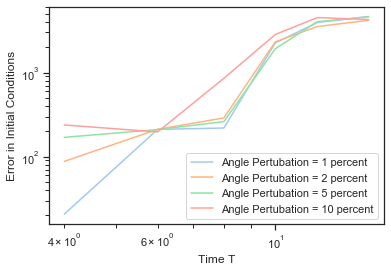

In [115]:
for i in range(len(p_angle)):
    plt.plot(Ts,errors[i], label = 'Angle Pertubation = %d percent'%(-100*(1-p_angle[i])))
plt.loglog()
plt.xlabel('Time T')
plt.ylabel('Error in Initial Conditions')
plt.legend()
plt.savefig('Angles.png', bbox_inches='tight', dpi = 800)

# Visuals

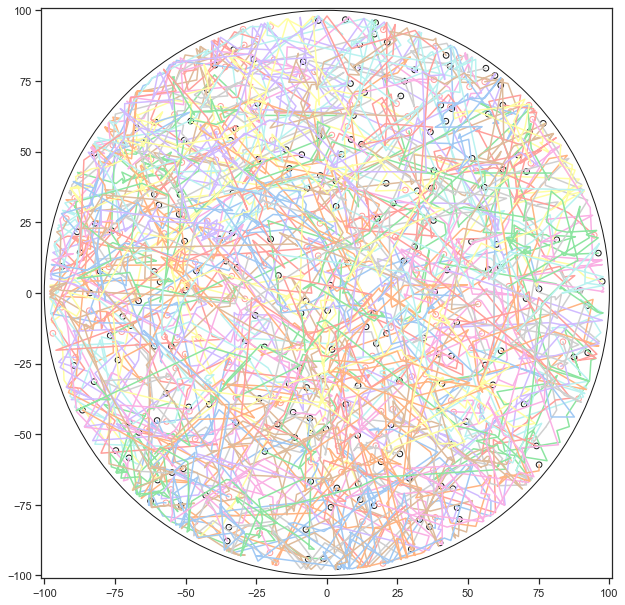

In [582]:
%matplotlib inline
xsx = np.array(xs)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_ylim(-(R+1),(R+1))
ax.set_xlim(-(R+1),(R+1))
ax.add_artist(circle1)
for i in range(N):
    ax.plot(xsx[i,:][:,0],xsx[i,:][:,1])    
    circle2 = plt.Circle((xsx[i][0][0], xsx[i][0][1]), 1, color='k', fill = False)
    ax.add_artist(circle2)
    circle3= plt.Circle((xsx[i][-1][0], xsx[i][-1][1]), 1, color='r', fill = False)
    ax.add_artist(circle3)
ax.set_aspect(1)

In [ ]:

%matplotlib notebook

xsx = np.array(xs)
R=100
N = 50

fig=plt.figure()
ax = plt.axes(xlim=(-(R+1),(R+1)), ylim=(-(R+1),(R+1)))
fig.set_size_inches(10, 10)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
ax.add_patch(circle1)
ax.set_aspect(1)


#ax = plt.axes(xlim=(0, 40), ylim=(0, 40))
rads = [atoms[i].radius for i in range(N)]
dict_of_circles = {}
for i in range(N):
    dict_of_circles["circle"+str(i+1)] = plt.Circle((xsx[i][0][0], xsx[i][0][1]),2,fc='b')

def init():
    for i in range(N):
        dict_of_circles["circle"+str(i+1)].center = (xsx[i][0][0], xsx[i][0][1])
        ax.add_patch(dict_of_circles["circle"+str(i+1)])
    return dict_of_circles.values()

def animate(i):
    for n in range(N):
        dict_of_circles["circle"+str(n+1)].center = (xsx[n][i][0], xsx[n][i][1])
    return dict_of_circles.values()

anim=animation.FuncAnimation(fig,animate,init_func=init,frames=len(xsx[0]),blit=True)
anim.save(
  filename='test.mp4',
  fps=30,
  dpi=200,
)